In [0]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
try: #python3
    from urllib.request import urlopen
except: #python2
    from urllib2 import urlopen

In [9]:
data_source = 'kaggle' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'YRW876LSLJDSZSG0'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Data','Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')


Loaded data from the Kaggle repository


In [10]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


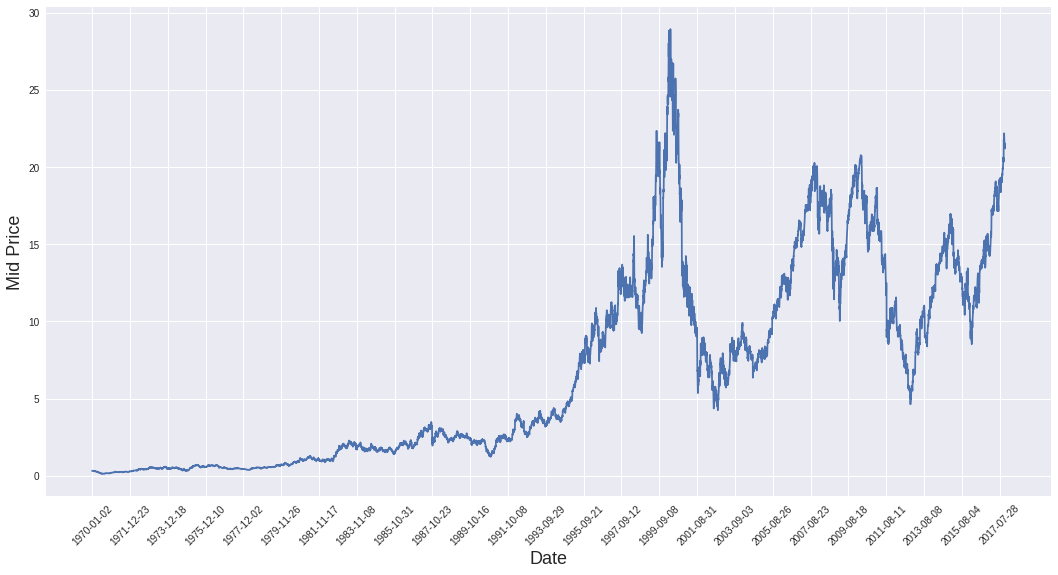

In [11]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [0]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

In [0]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

In [0]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [0]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [0]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [0]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [18]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00418


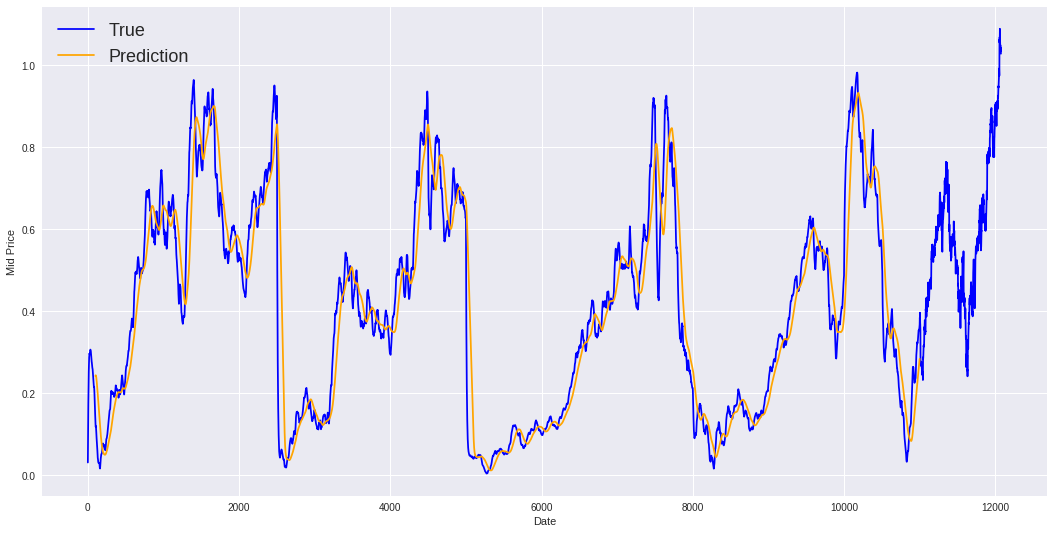

In [19]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [20]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00003


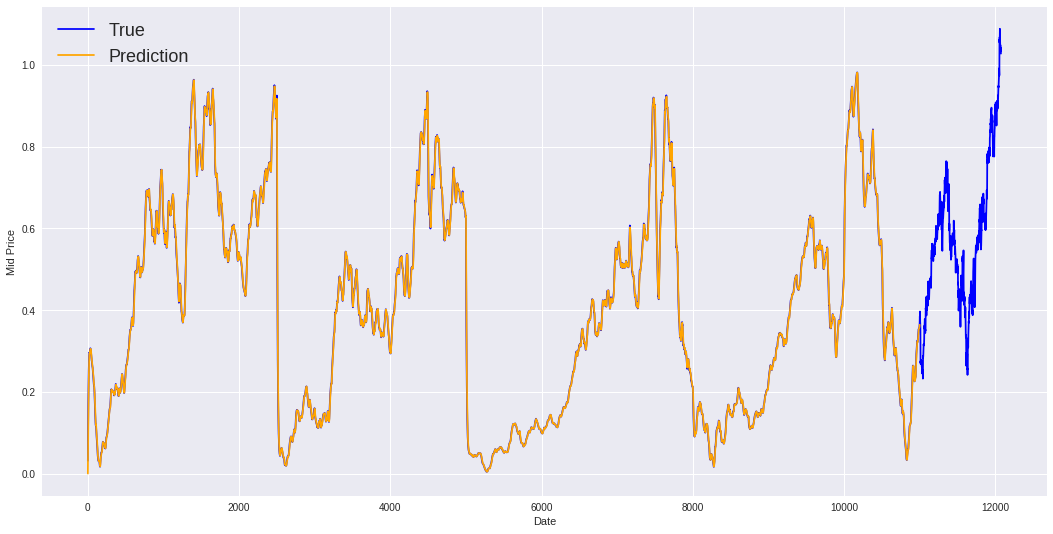

In [21]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [22]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
('\tInputs: ', array([0.03143791, 0.6904868 , 0.82829314, 0.32585657, 0.11600105],
      dtype=float32))
('\n\tOutput:', array([0.132895  , 0.6858036 , 0.83294916, 0.33078218, 0.11946969],
      dtype=float32))


Unrolled index 1
('\tInputs: ', array([0.06067836, 0.6890754 , 0.8325337 , 0.32857886, 0.11785509],
      dtype=float32))
('\n\tOutput:', array([0.11098009, 0.6836884 , 0.833141  , 0.33355275, 0.12192084],
      dtype=float32))


Unrolled index 2
('\tInputs: ', array([0.08698314, 0.68685144, 0.8329321 , 0.33078218, 0.11946969],
      dtype=float32))
('\n\tOutput:', array([0.15261841, 0.6826334 , 0.833369  , 0.33078218, 0.12230608],
      dtype=float32))


Unrolled index 3
('\tInputs: ', array([0.11098009, 0.6858036 , 0.83294916, 0.33219692, 0.12106793],
      dtype=float32))
('\n\tOutput:', array([0.15261841, 0.6848606 , 0.83420646, 0.33355275, 0.12106793],
      dtype=float32))


Unrolled index 4
('\tInputs: ', array([0.132895  , 0.6848606 , 0.833369  , 0.3

In [0]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [0]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [27]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [28]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))
# a = *[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)]
# b = *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)]
a = [tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)] + [tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)]
reset_sample_states = tf.group(*a)
sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),initial_state=tuple(initial_sample_state),time_major = True,dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+[tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [29]:
epochs = 300
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(11000,12000,50).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized
Average loss at step 1: 3.061664
	Test MSE: 0.04276
	Finished Predictions
Average loss at step 2: 0.167672
	Test MSE: 0.00843
	Finished Predictions
Average loss at step 3: 0.086284
	Test MSE: 0.00386
	Finished Predictions
Average loss at step 4: 0.074348
	Test MSE: 0.00337
	Finished Predictions
Average loss at step 5: 0.062853
	Test MSE: 0.00281
	Finished Predictions
Average loss at step 6: 0.058515
	Test MSE: 0.00258
	Finished Predictions
Average loss at step 7: 0.055433
	Test MSE: 0.00239
	Finished Predictions
Average loss at step 8: 0.054022
	Test MSE: 0.00353
	Finished Predictions
Average loss at step 9: 0.054050
	Test MSE: 0.00232
	Finished Predictions
	Test MSE: 0.00323
	Finished Predictions
Average loss at step 11: 0.048147
	Test MSE: 0.00235
	Finished Predictions
Average loss at step 12: 0.046077
	Decreasing learning rate by 0.5
	Test MSE: 0.00329
	Finished Predictions
Average loss at step 13: 0.041315
	Test MSE: 0.00234
	Finished Predictions
Average loss at step 14

Average loss at step 36: 0.041335
	Decreasing learning rate by 0.5
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 37: 0.040609
	Test MSE: 0.00238
	Finished Predictions
Average loss at step 38: 0.041670
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 39: 0.041314
	Decreasing learning rate by 0.5
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 40: 0.040981
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 41: 0.041750
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 42: 0.040086
	Decreasing learning rate by 0.5
	Test MSE: 0.00246
	Finished Predictions
Average loss at step 43: 0.039330
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 44: 0.039505
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 45: 0.039029
	Decreasing learning rate by 0.5
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 46: 0.039477
	Test MSE: 0.00239
	Finished Predictions
Average loss at step 47: 0.042418
	Test MSE

	Decreasing learning rate by 0.5
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 70: 0.041533
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 71: 0.040544
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 72: 0.038994
	Decreasing learning rate by 0.5
	Test MSE: 0.00248
	Finished Predictions
Average loss at step 73: 0.038765
	Test MSE: 0.00238
	Finished Predictions
Average loss at step 74: 0.039289
	Test MSE: 0.00248
	Finished Predictions
Average loss at step 75: 0.037731
	Decreasing learning rate by 0.5
	Test MSE: 0.00238
	Finished Predictions
Average loss at step 76: 0.040881
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 77: 0.039190
	Test MSE: 0.00239
	Finished Predictions
Average loss at step 78: 0.041149
	Decreasing learning rate by 0.5
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 79: 0.039884
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 80: 0.041601
	Test MSE: 0.00244
	Finished Predictions
Av

Average loss at step 103: 0.039048
	Test MSE: 0.00245
	Finished Predictions
Average loss at step 104: 0.038242
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 105: 0.039215
	Decreasing learning rate by 0.5
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 106: 0.039632
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 107: 0.036732
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 108: 0.041300
	Decreasing learning rate by 0.5
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 109: 0.039180
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 110: 0.038205
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 111: 0.039773
	Decreasing learning rate by 0.5
	Test MSE: 0.00238
	Finished Predictions
Average loss at step 112: 0.037685
	Test MSE: 0.00244
	Finished Predictions
Average loss at step 113: 0.037320
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 114: 0.039205
	Decreasing learning rate by 0

	Test MSE: 0.00237
	Finished Predictions
Average loss at step 137: 0.039673
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 138: 0.037612
	Decreasing learning rate by 0.5
	Test MSE: 0.00245
	Finished Predictions
Average loss at step 139: 0.037281
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 140: 0.039082
	Test MSE: 0.00237
	Finished Predictions
Average loss at step 141: 0.037121
	Decreasing learning rate by 0.5
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 142: 0.038966
	Test MSE: 0.00238
	Finished Predictions
Average loss at step 143: 0.038919
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 144: 0.036426
	Decreasing learning rate by 0.5
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 145: 0.038512
	Test MSE: 0.00244
	Finished Predictions
Average loss at step 146: 0.037552
	Test MSE: 0.00246
	Finished Predictions
Average loss at step 147: 0.037806
	Decreasing learning rate by 0.5
	Test MSE: 0.00239
	Finished Pre

Average loss at step 170: 0.036851
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 171: 0.039047
	Decreasing learning rate by 0.5
	Test MSE: 0.00248
	Finished Predictions
Average loss at step 172: 0.036603
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 173: 0.036652
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 174: 0.036072
	Decreasing learning rate by 0.5
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 175: 0.035433
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 176: 0.037623
	Test MSE: 0.00239
	Finished Predictions
Average loss at step 177: 0.038812
	Decreasing learning rate by 0.5
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 178: 0.038254
	Test MSE: 0.00249
	Finished Predictions
Average loss at step 179: 0.038261
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 180: 0.037975
	Decreasing learning rate by 0.5
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 181: 0.0353

	Test MSE: 0.00252
	Finished Predictions
Average loss at step 204: 0.035708
	Decreasing learning rate by 0.5
	Test MSE: 0.00245
	Finished Predictions
Average loss at step 205: 0.036480
	Test MSE: 0.00239
	Finished Predictions
Average loss at step 206: 0.038087
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 207: 0.035786
	Decreasing learning rate by 0.5
	Test MSE: 0.00238
	Finished Predictions
Average loss at step 208: 0.036980
	Test MSE: 0.00239
	Finished Predictions
Average loss at step 209: 0.036542
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 210: 0.035801
	Decreasing learning rate by 0.5
	Test MSE: 0.00245
	Finished Predictions
Average loss at step 211: 0.037624
	Test MSE: 0.00249
	Finished Predictions
Average loss at step 212: 0.035159
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 213: 0.035588
	Decreasing learning rate by 0.5
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 214: 0.035923
	Test MSE: 0.00239
	Finished Pre

Average loss at step 237: 0.034870
	Decreasing learning rate by 0.5
	Test MSE: 0.00247
	Finished Predictions
Average loss at step 238: 0.035533
	Test MSE: 0.00245
	Finished Predictions
Average loss at step 239: 0.035052
	Test MSE: 0.00245
	Finished Predictions
Average loss at step 240: 0.035545
	Decreasing learning rate by 0.5
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 241: 0.036396
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 242: 0.035701
	Test MSE: 0.00247
	Finished Predictions
Average loss at step 243: 0.035784
	Decreasing learning rate by 0.5
	Test MSE: 0.00244
	Finished Predictions
Average loss at step 244: 0.036019
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 245: 0.033039
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 246: 0.035713
	Decreasing learning rate by 0.5
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 247: 0.035473
	Test MSE: 0.00246
	Finished Predictions
Average loss at step 248: 0.0352

	Decreasing learning rate by 0.5
	Test MSE: 0.00240
	Finished Predictions
Average loss at step 271: 0.035759
	Test MSE: 0.00243
	Finished Predictions
Average loss at step 272: 0.034869
	Test MSE: 0.00244
	Finished Predictions
Average loss at step 273: 0.035437
	Decreasing learning rate by 0.5
	Test MSE: 0.00247
	Finished Predictions
Average loss at step 274: 0.033779
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 275: 0.034170
	Test MSE: 0.00242
	Finished Predictions
Average loss at step 276: 0.034034
	Decreasing learning rate by 0.5
	Test MSE: 0.00239
	Finished Predictions
Average loss at step 277: 0.034408
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 278: 0.033711
	Test MSE: 0.00246
	Finished Predictions
Average loss at step 279: 0.035516
	Decreasing learning rate by 0.5
	Test MSE: 0.00241
	Finished Predictions
Average loss at step 280: 0.034960
	Test MSE: 0.00245
	Finished Predictions
Average loss at step 281: 0.034105
	Test MSE: 0.00242
	Finished Pre

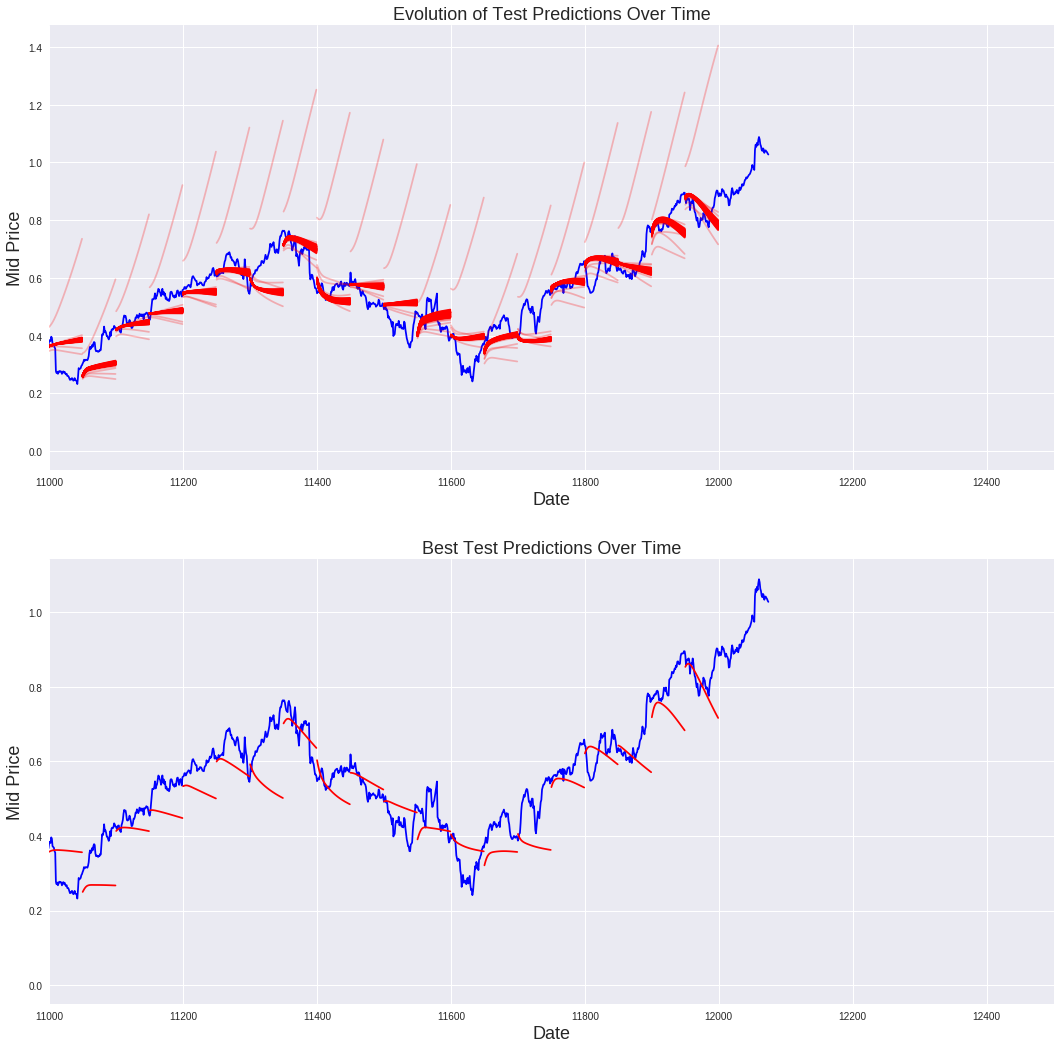

In [30]:
best_prediction_epoch = 9 # 0.00232 replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()